###### Last update: 2022-04-25 (YYYY-MM-DD)
# Example: Performing Fluid Flow Simulation using a Remote Simulation API

## Author: Jerome O.

## 1. Introduction

This notebook shows a simple application of a remote API to perform simulate subsurface fluid flow in porous media. If you are not a petroleum or reservoir engineer, please see the wiki (page add links) for some background on reservoir simulation, and this blog for application using simple reservoir models. 

The example model here is a three-dimensional model with grid dimensions of 24 x 25 x 15. We have intentionally choosen a model with smaller grid because so the computations on remote server can finish sooner. Generally, larger models require more computational resources and the simulations require more time to complete.  

A main benefit of this API is that is would help students and researches from third-world countries who do not have access to third-party fluid simulators or advanced routines (such as in the application used here) to carry out advanced research. 

To use the API, a user creates data relevant for their simulation (see example below). They issue an HTTP request and if the simulation is successful, the result is a set of time-series parameters for different quantities. These time-series are used to create plots of the production profile vs. time. 

### 1.1 Synchronous vs. Asynchronous HTTP Requests
The methods for submitting the HTTP requests are provided. The **Synchronous** post request is a synchronous call and the requests blocks until the response is returned back to the client. This option is not very responsive and provides no status updates to the user. The **Asynchronous** post requests submits the request asynchronously and continously poss the remote server for job status (percent completion) and when the job is completed, returns the time-series objects.

We should always care about our users and their experience when using our applications. For this reason, the **asynchronous** call is recommended because it provide feedback on remote job status although it has a more complicated code (uses event-driven architecture and message queues). The **synchronous** request option is useful for testing and debugging purposes as its code path is much simpler. The results from both approaches are exactly the same.

## 2. Import packages and functions

In [1]:
import json, time, math
from demo_utils import create_project, get_request, submit_request, print_json, make_plot, progress_bar
from demo_utils import get_request_auth, post_request_auth

## 3. Authorization Token

To be able to run the remote simulation, one needs an authorization **token** and a **project id** (key). To obtain a token to run the example model, please send an email with your first name to me at jeronwunalu@gmail.com

### 3.1 Obtain Authorization Token

If you have obtained an authorization token, you can test that it works by issuing a GET http request to https://simapi.thedibia.com/hello. If the request is successful a JSON with key "message" and value "Hello <name>!" is returned.

### 3.2 Test Authorization Token
#### Get Request to Hello API

In [19]:
token        = '06829778a6474fe2c15d5687a315fba5f9e385ba' #<- add your token here # bermuda
auth_headers = {"Authorization" : f"Token {token}"}
hello_data   = None
#url          = 'http://localhost:8000/hello_cache/john' #<-local pandora
url          = 'https://simapi.thedibia.com/hello'
results      = get_request_auth(hello_data, url, auth_headers)
if results:
    print_json(results)

{
    "message": "Hello tdba!"
}


## 4. Example 

### 4.1 Define Simulation Parameters: Well Types and Well Locations

Here we show how to define well parameters in the simulation model. Basically, we need to specify the **type** and **location** of the wells. The **type** of the well could be an oil **producer** (represented by 0) or a water **injector** (represented by 1). The oil producers produce oil to the surface while the water injector is used to injector water in the reservoir to improve recovery and maintain pressure. 

The **location** of each well is defined by specifying the (I,J,K) indices of the **start** and **end** grid blocks of the well. The example below is based on the SPE9 model and the original model contains 26 oil producers and 1 water injector. The start and end grid block of the first oil producer (named **producer_1**) are (5, 1, 2) and (5, 1, 4) respectively. For the second producer (**producer_2**) the start and end grids are (8, 2, 2) and (8, 2, 4), and for the water injector (**injector_1**), the corresponding values are (24, 25, 11) and (24, 25, 15). See below for a complete specification of all the wells. See next section for a full specification of the wells.

### 4.2 Specifying Well Types and Locations

The model contains 2 oil producers and 1 water injector. The wells are defined as an array of well parameters. Each well is defined by three parameters:

1 - well type: 0 for producer, 1 for water injector

2 - well toe location grid specified by 3 indicies (i,j,k)

3 - well heel location grid specified by 3 indicies (i,j,k)

In [22]:
# Well parameters for the 3 wells of the reservoir model
well_parameters = [[0, [100,1,1],[100,1,1]],
                   [1, [50,1,1], [50,1,1]],
                   [0, [1,1,1],[1,1,1]]]    

In [135]:
# Add a plot of the well locations and grid 
# add a link to show the simulations as a youtube video

### 4.3 Initialize token, project_id parameters

In [29]:
URL          = "http://127.0.0.1:8000/api/simulations"
SIM_URL      = "https://simapi.thedibia.com/api/simulations"
project_id   =  "2d92db18-314d-4e5d-8f58-d079883af7f5"
sim_duration = 1000 # simulation in days # should be less than 10,000 days
  

## 5. Specify data for HTTP Post Request

Here we define JSON data that we will use to make the request to the remote application. There are additional data that can be specified in the JSON structure but I have opted for a simplified data format. Below we show an example JSON data that includes the well configurations ("parameters") and another to control the duration of the simulation ("simulation-duration"). The unit of the simulation duration is days.

### 5.1 Synchronous vs. Asynchronous HTTP Request

Both synchronous and asynchronous HTTP requests can be made depending on data passed to the remote machine. With a synchronous HTTP request, the requests blocks until the remote simulations is completed. For the asynchoronous case, the initial HTTP request returns and we keep polling to get status of the remote jobs. When the status is 100%, then the simulation results are return. Both approaches return exactly the same results. 

In [30]:
# ASYNCHRONOUS DATA SETUP
# asynchronous remote call (with updates on status of remote simulation job)
# For this case, the HTTP request returns and subsequent calls return the percent complete of the remote job
data_with_updates ={'input_format'        : 'simple',
                    'job_updates'         : 'yes',
                    'project_id'          : project_id,       
                    'parameters'          : str(json.dumps(well_parameters)), 
                    'simulation-duration' : sim_duration
                   }

print_json(data_with_updates)

{
    "input_format": "simple",
    "job_updates": "yes",
    "project_id": "2d92db18-314d-4e5d-8f58-d079883af7f5",
    "parameters": "[[0, [100, 1, 1], [100, 1, 1]], [1, [50, 1, 1], [50, 1, 1]], [0, [1, 1, 1], [1, 1, 1]]]",
    "simulation-duration": 1000
}


In [49]:
# SYNCHRONOUS CALL
# synchronous remote call (no updates on status of remote simulation job) For this case, the call blocks until the
# remote simulation is complete
data_no_updates ={           
                  'project_id'          : project_id,       
                  'parameters'          : str(json.dumps(well_parameters)), 
                  'simulation-duration' : sim_duration
                 }


print_json(data_no_updates)
#str(data_no_updates)

{
    "project_id": "2d92db18-314d-4e5d-8f58-d079883af7f5",
    "parameters": "[[0, [100, 1, 1], [100, 1, 1]], [1, [50, 1, 1], [50, 1, 1]], [0, [1, 1, 1], [1, 1, 1]]]",
    "simulation-duration": 1000
}


## 6. Remote Simulation - Example Results
After the creating the data as discussed above, the next step is to submit the request to the remote API. If the request is successful, a time series plot of the fluid production profile is generated. Figures 1 shows the  expected production and injection profiles for a simulation duration of 5000 days. 

<img src="spe9_cloud_sim_5000_days.png" width=500 height=300 />
<p><center>Figure 1: Oil and water production and injection profiles (time series) for 5000 days simulation.</center> </p>

The user can change this simulation duration to any value in the interval (0,5000] and a different production profile (time series) accordingly. 

## 7. Exercise: Submit Remote Job

The user can test the remote simulation API give a valid apiKey (project_id). If you would like to try this, please send an email to the author. After obtaining the key, replace the **project_id** variable defined early. Then you can run the command in the next cell to perform the simulation on the remote server.

### 7.1 Functions To Submit Jobs

In [ ]:
### We issue an HTTP request to the URL and the results are returned when the simulation finishes.

# Synchronous HTTP requests with job no updates from remote server - call blocks until completion.
def run_remote_job_no_updates(data, URL, token):
    auth_headers = {"Authorization" : f"Token {token}"}
    print(f"Step 1 - Submitting job to remote server: simulation duration {data['simulation-duration']} days ...")    
    http_code, response, response_headers = post_request_auth(data, URL, auth_headers)
    #print(http_code)
    if http_code == 201 and response:
        response_json = response.json()
        print(f'Step 2 - Constructing production (time-series) plots ...')
        results = response_json[0]                
        make_plot(results)
    else:
        print(response.json())
                
# Asynchronous HTTP requests with job updates from remote server
def run_remote_job_with_updates(data, URL, token):
    auth_headers = {"Authorization" : f"Token {token}"}
    print(f"Step 1 - Submitting job to remote server: {URL}")    
    http_code, results, response_headers = post_request_auth(data, URL, auth_headers)
    print(f"Step 2 - Job id on remote machine = {response_headers['Job-Id']}) ...")
    print(f"Step 3 - Tracking job progress ...")
    print(f'{http_code}, {results}')
    if http_code == 202 or 200:    
        status_uri = response_headers['Content-Location']          
        request_headers={"Current-Time-Day" : "0"}       
        while True:
            request_headers.update(auth_headers)        
            status, response_json, response_headers = get_request(status_uri, request_headers)                 
            if status == 200 and response_json:
                response_json = json.loads(response_json)                       
                progress = math.ceil(response_json['progress'])   
                message  = response_json['message']                               
                end = "" if progress < 100 else "\n"
                if progress > 0:
                    #print(f'\r\t Progress (%) - {progress_bar(progress)}, Current - {curday:7} days, Max {maxday:7}',end=end)                
                    print(f'\r\t {message}',end=end)
                #request_headers={"Current-Time-Day" : str(curday)}
                if progress >= 100:
                    resource_uri = response_headers['Content-Location']
                    if resource_uri:                    
                        print(f'Step 4 - Retrieving results ...')
                        while True:
                            status, response_json, _ = get_request(resource_uri,auth_headers)
                            print(status)
                            if response_json:
                                print(f'Step 5 - Constructing production (time-series) plots ...')
                                results = response_json                                     
                                make_plot(results)
                                break
                    break
            time.sleep(1)



### 7.2 Synchronous HTTP Request
With Synchronous HTTP request, no updates on remote job status is sent back to the client. T\This is not an ideal situation and use case, because the user has no information on the remote job status (queued, started, running, etc) and if the job is running, what is the percentage complete. 

The application supports synchronous HTTP request option for testing small models where the remote jobs takes a few seconds.

Step 1 - Submitting job to remote server: duration 1000 days ...
Step 2 - Constructing production (time-series) plots ...


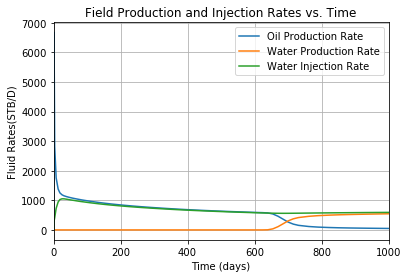

In [51]:
# Synchronous HTTP request (no updates are return from remote server)
run_remote_job_no_updates(data_no_updates, SIM_URL, token)            

### 7.3 Multiple runs with different simulation durations
In the section, we illustrate how to perform multiple simulations with varying total simulation days (durations). In the example below we use the same data as the previous examples but vary the total simulation period from 100 to 500 days at intervals of 100 days. This is reflected in the results. The user is welcome to try different intervals.

Step 1 - Submitting job to remote server: duration 100 days ...
Step 2 - Constructing production (time-series) plots ...
Step 1 - Submitting job to remote server: duration 200 days ...
Step 2 - Constructing production (time-series) plots ...


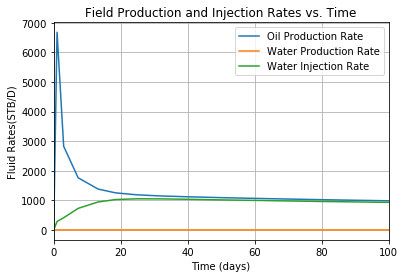

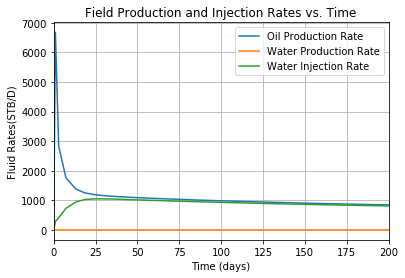

In [52]:
durations = [100, 200]# , 300, 400, 500]
for duration in durations:
    data_no_updates['simulation-duration'] = duration
    run_remote_job_no_updates(data_no_updates, SIM_URL, token)         
    

### 7.3 Asynchronous HTTP Request (with updates on job status)

In [28]:
# Asynchronous HTTP request (the function polls the request server for job completion status)
run_remote_job_with_updates(data_with_updates, SIM_URL, token)            

KeyboardInterrupt: 

## 7.4 Retrieve Job Results

After a job is completed, it can be retrieved again (via a GET request) if we know it's job id. Use the job id from the asynchronous request to retrieve the job.

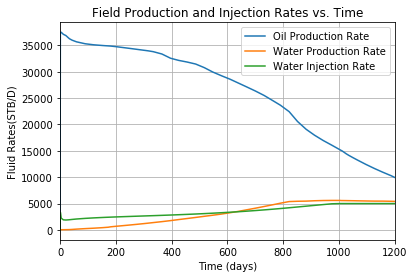

In [88]:
auth_headers = {"Authorization" : f"Token {token}"}
hello_data   = None
url          = 'http://localhost:8000/api/simulations/b88d2613-ff13-44b1-a803-8c8a0e6f309a'
url          = 'https://simapi.thedibia.com/api/simulations/48f8af4c-3d09-421e-9a0a-455e6af784da'
results      = get_request_auth(hello_data, url, auth_headers)
if results:
    #print_json(results)
    make_plot(results)

## 8. Conclusion